
Training with learning rate: 0.0001
Iteration 0: Cost = 0.6931, Val Cost = 0.6926, Train Acc = 66.76%, Test Acc = 67.41%
Iteration 100: Cost = 0.6396, Val Cost = 0.6389, Train Acc = 67.61%, Test Acc = 68.21%
Iteration 200: Cost = 0.5954, Val Cost = 0.5945, Train Acc = 68.41%, Test Acc = 68.81%
Iteration 300: Cost = 0.5586, Val Cost = 0.5576, Train Acc = 69.08%, Test Acc = 69.50%
Iteration 400: Cost = 0.5279, Val Cost = 0.5268, Train Acc = 69.67%, Test Acc = 69.97%
Iteration 500: Cost = 0.5021, Val Cost = 0.5010, Train Acc = 70.14%, Test Acc = 70.51%
Iteration 600: Cost = 0.4802, Val Cost = 0.4791, Train Acc = 70.58%, Test Acc = 70.90%
Iteration 700: Cost = 0.4616, Val Cost = 0.4605, Train Acc = 70.95%, Test Acc = 71.41%
Iteration 800: Cost = 0.4456, Val Cost = 0.4445, Train Acc = 71.30%, Test Acc = 71.70%
Iteration 900: Cost = 0.4318, Val Cost = 0.4307, Train Acc = 71.57%, Test Acc = 71.92%
Iteration 1000: Cost = 0.4198, Val Cost = 0.4187, Train Acc = 71.78%, Test Acc = 72.20%
Iterati

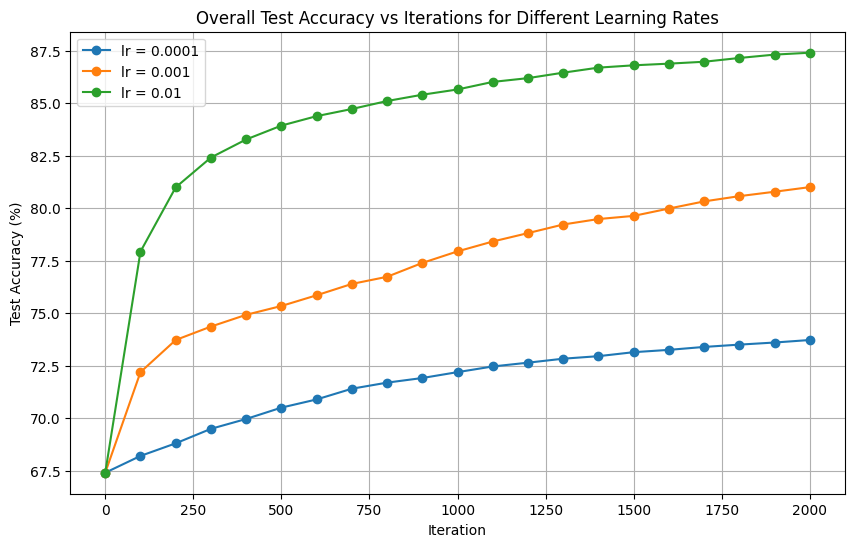

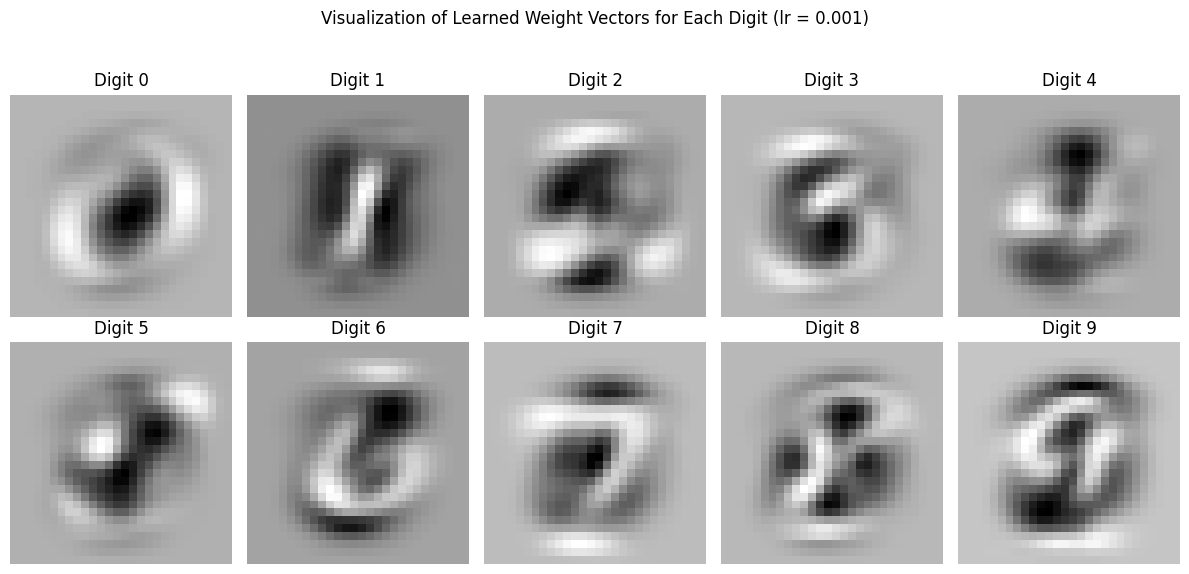

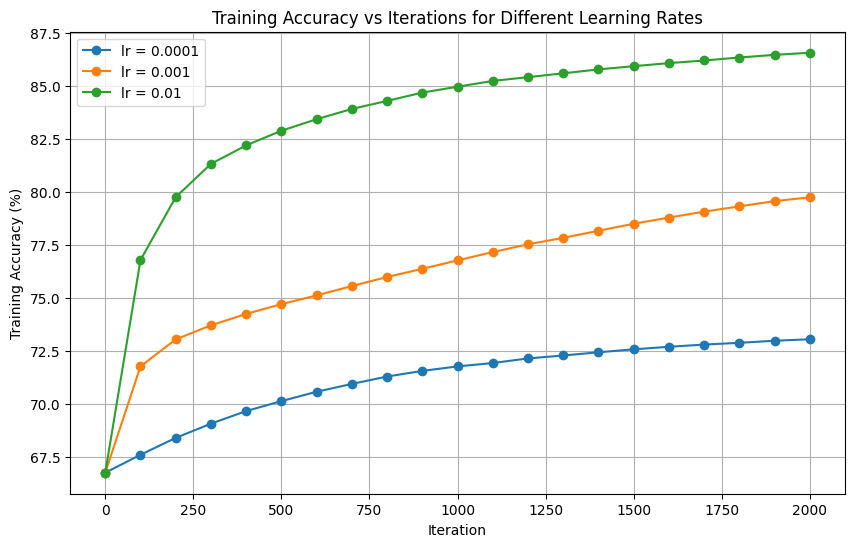

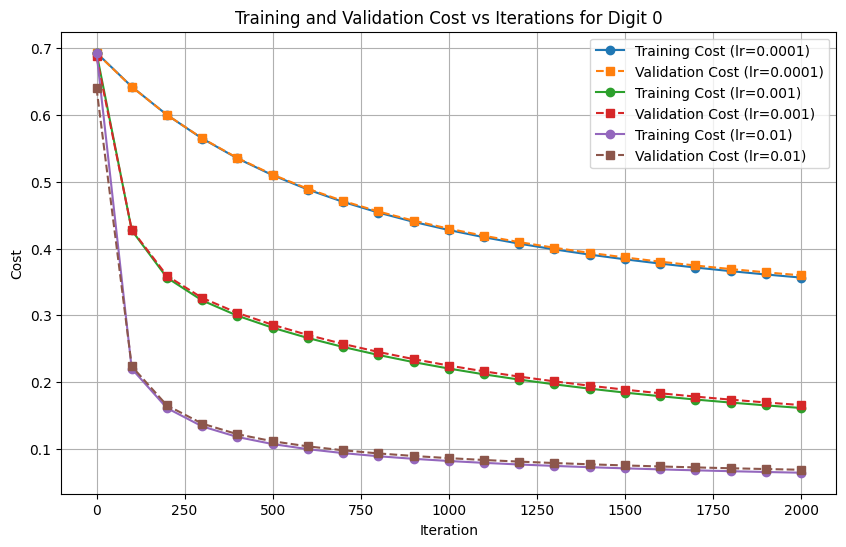

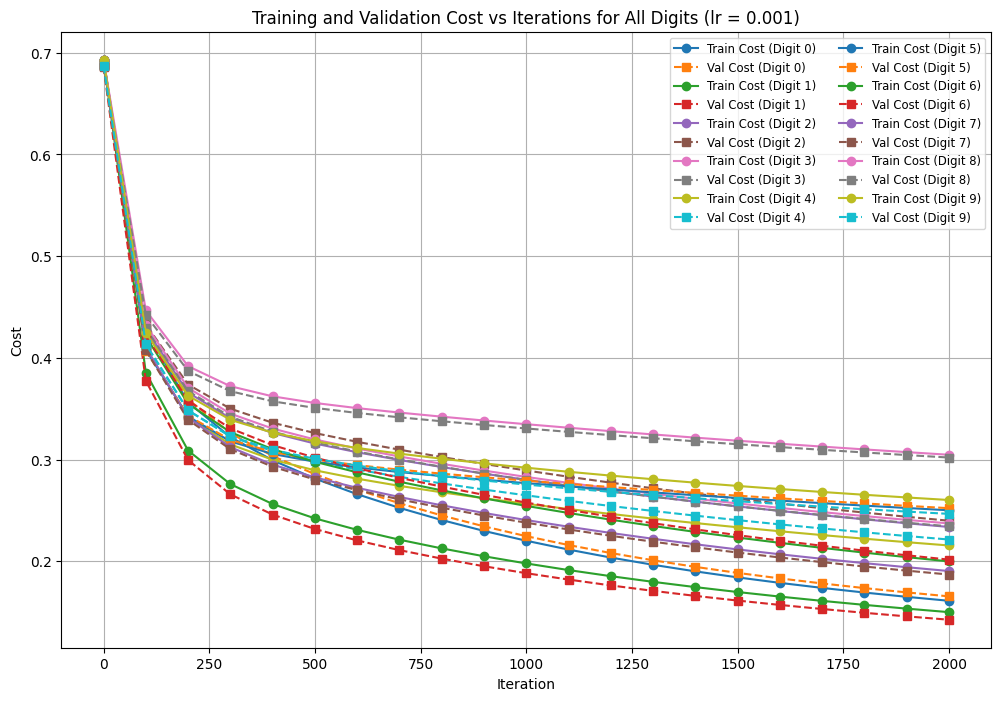

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load MNIST dataset using TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Shuffle the training data 
perm = np.random.permutation(x_train.shape[0])
x_train = x_train[perm]
y_train = y_train[perm]

# Split a portion of training data for validation (10%)
val_count = int(0.1 * x_train.shape[0])
x_val = x_train[-val_count:]
y_val = y_train[-val_count:]
x_train = x_train[:-val_count]
y_train = y_train[:-val_count]

# Reshape images: flatten each image into a column vector (28x28 → 784)
x_train = x_train.reshape(x_train.shape[0], -1).T
x_val = x_val.reshape(x_val.shape[0], -1).T
x_test = x_test.reshape(x_test.shape[0], -1).T

# Convert labels to shape (1, m)
y_train = y_train.reshape(1, -1)
y_val = y_val.reshape(1, -1)
y_test = y_test.reshape(1, -1)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def initialize_with_zeros(dim):
    return np.zeros((dim, 1)), 0

def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)  # Compute activation
    # Compute cost
    cost = - (1 / m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)
    
    assert(dw.shape == w.shape)
    assert(isinstance(db, float))
    cost = np.squeeze(cost)  # Ensure cost is a scalar
    assert(np.isscalar(cost))
    
    grads = {"dw": dw, "db": db}
    
    return grads, cost

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

num_classes = 10
num_iterations = 2000
learning_rates = [0.0001, 0.001, 0.01]
results = {}

# Train models for different learning rates
for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Initialize results for this learning rate
    results[lr] = {"models": None, "iterations": [], "test_acc": [], "train_acc": []}
    
    # Initialize models for each digit classifier
    models = {digit: {"w": np.zeros((x_train.shape[0], 1)), 
                      "b": 0, 
                      "costs": [], 
                      "val_costs": []} for digit in range(num_classes)}
    
    for i in range(0, num_iterations + 1):
        for digit in range(num_classes):
            # Create binary labels for the current digit classifier
            Y_train_binary = (y_train == digit).astype(np.float32)
            
            # Compute gradients and cost
            grads, cost = propagate(models[digit]["w"], models[digit]["b"], x_train, Y_train_binary)
            
            # Gradient descent update
            models[digit]["w"] -= lr * grads["dw"]
            models[digit]["b"] -= lr * grads["db"]
            
            if i % 100 == 0:
                models[digit]["costs"].append(cost)
                
                # Compute validation cost for the current model
                Y_val_binary = (y_val == digit).astype(np.float32)
                val_probs = sigmoid(np.dot(models[digit]["w"].T, x_val) + models[digit]["b"])
                val_cost = - (1 / x_val.shape[1]) * np.sum(Y_val_binary * np.log(val_probs) + (1 - Y_val_binary) * np.log(1 - val_probs))
                
                models[digit]["val_costs"].append(val_cost)
        
        # Compute overall training and test accuracy every 100 iterations
        if i % 100 == 0:
            # Compute probabilities for training data for each digit classifier
            train_probs = np.array([
                sigmoid(np.dot(models[d]["w"].T, x_train) + models[d]["b"])
                for d in range(num_classes)
            ]).squeeze()
            train_pred = np.argmax(train_probs, axis=0)
            train_acc = np.mean(train_pred == y_train)
        
            # Compute probabilities for test data
            test_probs = np.array([
                sigmoid(np.dot(models[d]["w"].T, x_test) + models[d]["b"])
                for d in range(num_classes)
            ]).squeeze()
            overall_pred = np.argmax(test_probs, axis=0)
            overall_acc = np.mean(overall_pred == y_test)
        
            # Compute average cost and validation cost across all classifiers
            avg_cost = np.mean([models[d]["costs"][-1] for d in range(num_classes)])
            avg_val_cost = np.mean([models[d]["val_costs"][-1] for d in range(num_classes)])
        
            print(f"Iteration {i}: Cost = {avg_cost:.4f}, Val Cost = {avg_val_cost:.4f}, "
                  f"Train Acc = {train_acc * 100:.2f}%, Test Acc = {overall_acc * 100:.2f}%")
            
            # Save metrics for plotting
            results[lr]["iterations"].append(i)
            results[lr]["train_acc"].append(train_acc * 100)  # in percentage
            results[lr]["test_acc"].append(overall_acc * 100)   # in percentage
    
    results[lr]["models"] = models

#########################################################################
# Plot: Overall Test Accuracy vs Iterations for Different Learning Rates
#########################################################################

plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(results[lr]["iterations"], results[lr]["test_acc"], marker='o', label=f"lr = {lr}")
plt.title("Overall Test Accuracy vs Iterations for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

############################################
# Plot: Weight Visualization for lr = 0.001
############################################

plt.figure(figsize=(12, 6))
for digit in range(num_classes):
    plt.subplot(2, 5, digit + 1)
    # Reshape weights into 28x28 for visualization
    w_image = results[0.001]["models"][digit]["w"].reshape(28, 28)
    # Normalize for visualization
    w_image = (w_image - np.min(w_image)) / (np.max(w_image) - np.min(w_image) + 1e-8)
    plt.imshow(w_image, cmap='gray')
    plt.title(f"Digit {digit}")
    plt.axis('off')

plt.suptitle("Visualization of Learned Weight Vectors for Each Digit (lr = 0.001)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#####################################################################
# Plot: Training Accuracy vs Iterations for All Learning Rates
#####################################################################

plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(results[lr]["iterations"], results[lr]["train_acc"], marker='o', linestyle='-', label=f"lr = {lr}")
plt.title("Training Accuracy vs Iterations for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
############################################################################################
# Plot: Training and Validation Cost vs Iterations for Digit 0 for Different Learning Rates
############################################################################################
plt.figure(figsize=(10, 6))
iterations = list(range(0, num_iterations + 1, 100))
for lr in learning_rates:
    # Extract the training and validation costs for digit 0
    training_costs = results[lr]["models"][0]["costs"]
    validation_costs = results[lr]["models"][0]["val_costs"]
    
    plt.plot(iterations, training_costs, marker='o', linestyle='-', label=f"Training Cost (lr={lr})")
    plt.plot(iterations, validation_costs, marker='s', linestyle='--', label=f"Validation Cost (lr={lr})")

plt.title("Training and Validation Cost vs Iterations for Digit 0")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()

###########################################################################################
# Plot: Training and Validation Cost vs Iterations for All Digits for Different Learning Rates
###########################################################################################
selected_lr = 0.001
models_lr = results[selected_lr]["models"]
iterations = list(range(0, num_iterations + 1, 100))

plt.figure(figsize=(12, 8))
for digit in range(num_classes):
    plt.plot(iterations, models_lr[digit]["costs"], marker='o', linestyle='-', 
             label=f"Train Cost (Digit {digit})")
    plt.plot(iterations, models_lr[digit]["val_costs"], marker='s', linestyle='--', 
             label=f"Val Cost (Digit {digit})")

plt.title("Training and Validation Cost vs Iterations for All Digits (lr = 0.001)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend(fontsize='small', ncol=2)
plt.grid(True)
plt.show()





Training with learning rate: 0.0001
Iteration 0: Cost = 2.3026, Val Cost = 2.3025, Train Acc = 67.03%, Test Acc = 67.94%
Iteration 100: Cost = 2.2918, Val Cost = 2.2917, Train Acc = 67.40%, Test Acc = 68.31%
Iteration 200: Cost = 2.2811, Val Cost = 2.2809, Train Acc = 67.77%, Test Acc = 68.66%
Iteration 300: Cost = 2.2706, Val Cost = 2.2703, Train Acc = 68.11%, Test Acc = 68.88%
Iteration 400: Cost = 2.2601, Val Cost = 2.2598, Train Acc = 68.41%, Test Acc = 69.05%
Iteration 500: Cost = 2.2497, Val Cost = 2.2494, Train Acc = 68.74%, Test Acc = 69.31%
Iteration 600: Cost = 2.2394, Val Cost = 2.2391, Train Acc = 69.04%, Test Acc = 69.60%
Iteration 700: Cost = 2.2293, Val Cost = 2.2288, Train Acc = 69.31%, Test Acc = 69.79%
Iteration 800: Cost = 2.2192, Val Cost = 2.2187, Train Acc = 69.59%, Test Acc = 70.10%
Iteration 900: Cost = 2.2091, Val Cost = 2.2086, Train Acc = 69.86%, Test Acc = 70.36%
Iteration 1000: Cost = 2.1992, Val Cost = 2.1986, Train Acc = 70.10%, Test Acc = 70.60%
Iterati

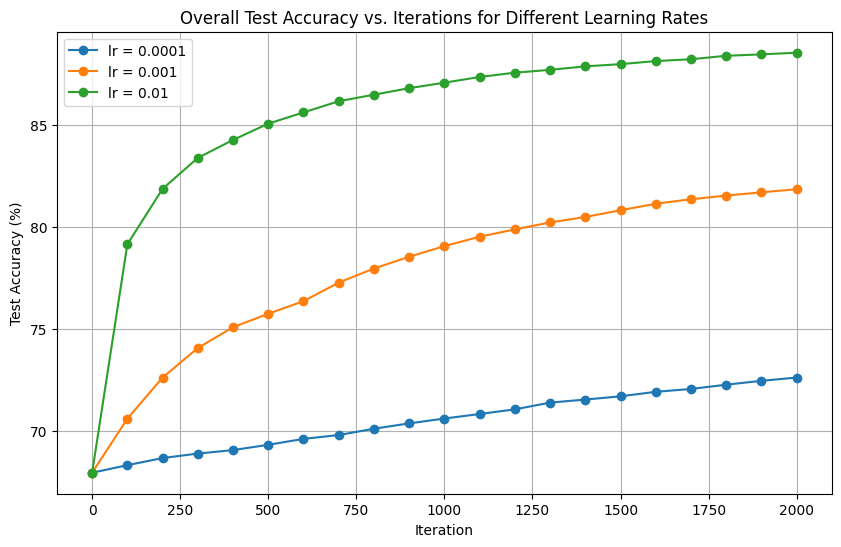

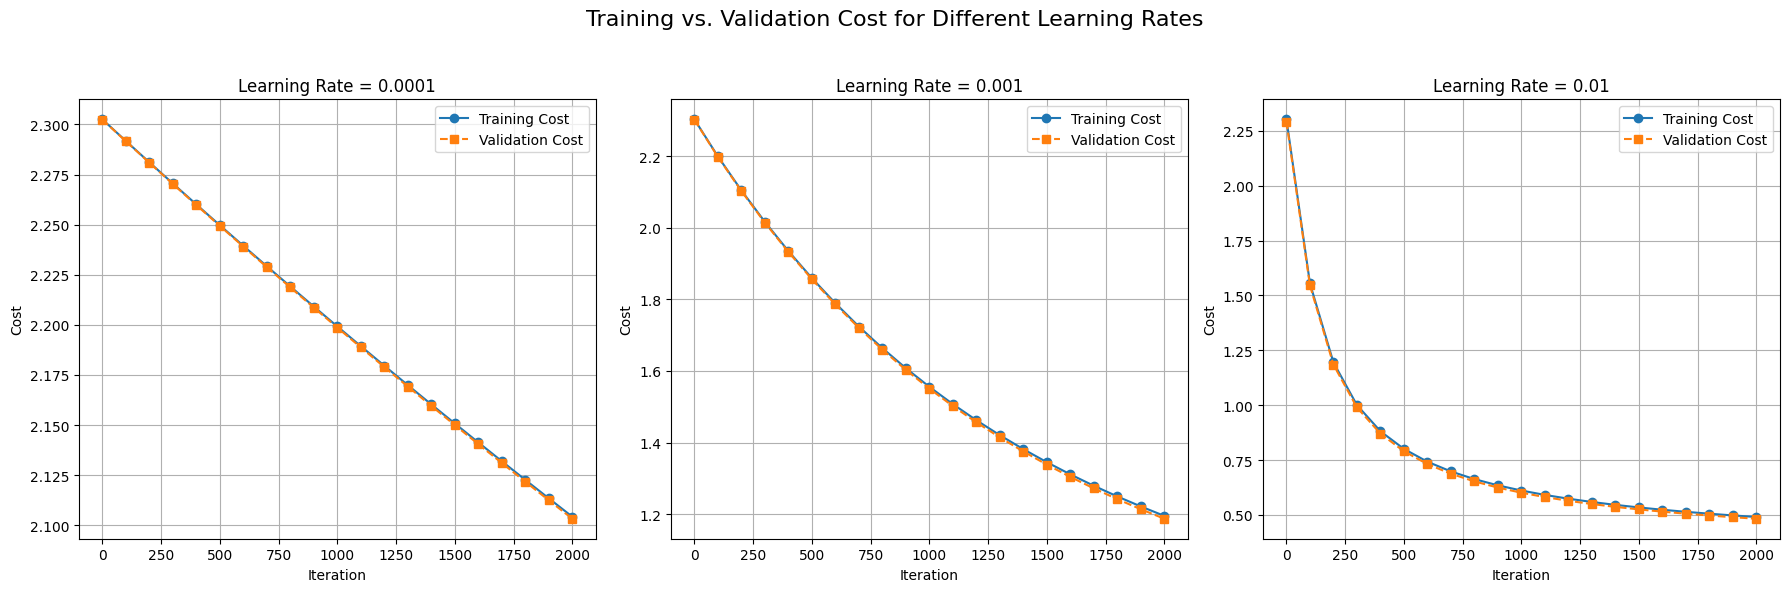

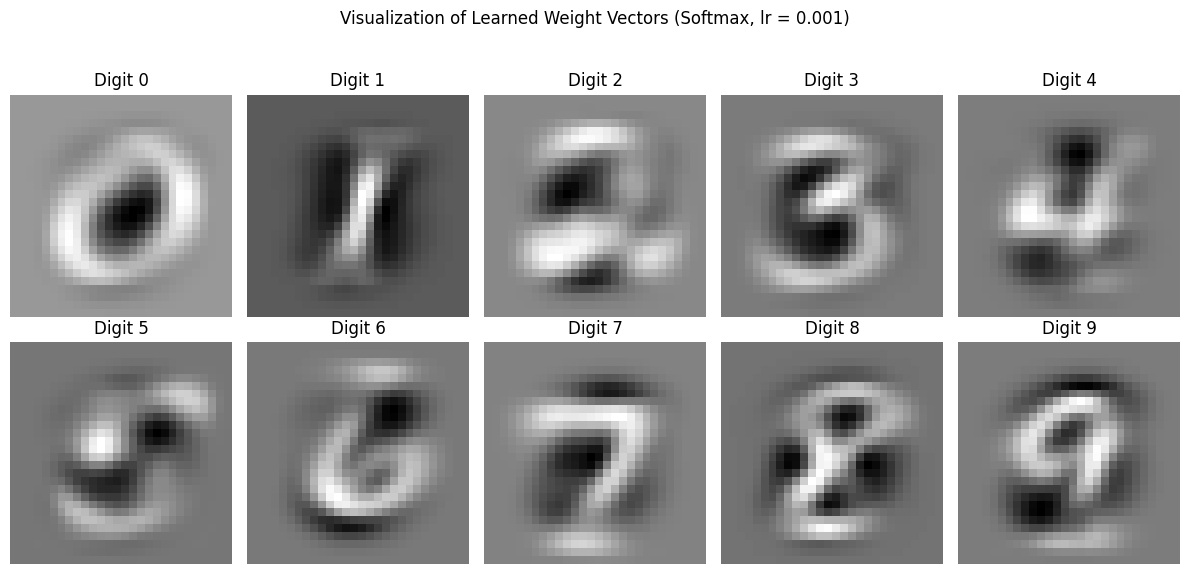

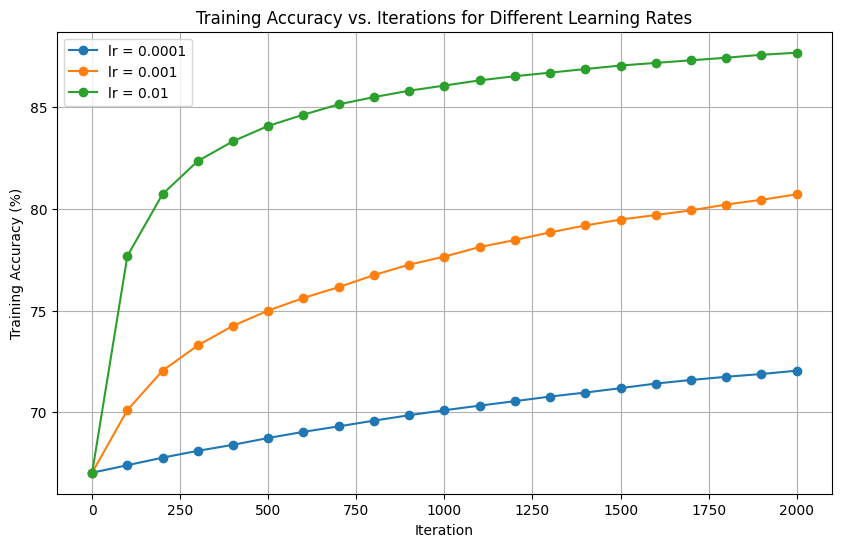

In [3]:
# Neural Network with Softmax Activation Function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Shuffle the training data
perm = np.random.permutation(x_train.shape[0])
x_train = x_train[perm]
y_train = y_train[perm]

# Split 10% of training data for validation
val_count = int(0.1 * x_train.shape[0])
x_val = x_train[-val_count:]
y_val = y_train[-val_count:]
x_train = x_train[:-val_count]
y_train = y_train[:-val_count]

# Reshape images: flatten each image into a column vector (28x28 → 784)
x_train = x_train.reshape(x_train.shape[0], -1).T   
x_val   = x_val.reshape(x_val.shape[0], -1).T         
x_test  = x_test.reshape(x_test.shape[0], -1).T       

num_classes = 10

def one_hot_encode(y, num_classes):
    m = y.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[y, np.arange(m)] = 1
    return one_hot

Y_train = one_hot_encode(y_train, num_classes)
Y_val   = one_hot_encode(y_val, num_classes)   
Y_test  = one_hot_encode(y_test, num_classes)   

def softmax(z):
    z_shift = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def propagate(W, b, X, Y):
    m = X.shape[1]
    
    # Forward propagation: compute Z and then softmax activation
    Z = np.dot(W.T, X) + b      
    A = softmax(Z)                 
    
    # Compute the cross-entropy cost
    cost = -np.sum(Y * np.log(A)) / m
    
    # Backward propagation: compute dW and db
    dZ = A - Y                   
    dW = np.dot(X, dZ.T) / m       
    db = np.sum(dZ, axis=1, keepdims=True) / m  
    
    cost = np.squeeze(cost)
    grads = {"dW": dW, "db": db}
    return grads, cost

def predict(W, b, X):
    Z = np.dot(W.T, X) + b
    A = softmax(Z)
    predictions = np.argmax(A, axis=0)
    return predictions

num_iterations = 2000
learning_rates = [0.0001, 0.001, 0.01]

results = {}

n_x = x_train.shape[0] 

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    # Initialize parameters
    W = np.zeros((n_x, num_classes))
    b = np.zeros((num_classes, 1))
    
    costs = []
    val_costs = []
    train_acc_list = []
    test_acc_list = []
    iterations_list = []
    
    m_train = x_train.shape[1]
    m_val = x_val.shape[1]
    
    for i in range(0, num_iterations+1):
        grads, cost = propagate(W, b, x_train, Y_train)
        dW = grads["dW"]
        db = grads["db"]
        
        # Update parameters
        W = W - lr * dW
        b = b - lr * db
        
        # Record progress every 100 iterations
        if i % 100 == 0:
            # Record training cost
            costs.append(cost)
            
            # Compute validation cost (forward pass on validation set)
            Z_val = np.dot(W.T, x_val) + b
            A_val = softmax(Z_val)
            val_cost = -np.sum(Y_val * np.log(A_val)) / m_val
            val_costs.append(val_cost)
            
            # Compute accuracies
            train_pred = predict(W, b, x_train)
            train_acc = np.mean(train_pred == y_train) * 100
            
            test_pred = predict(W, b, x_test)
            test_acc = np.mean(test_pred == y_test) * 100
            
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            iterations_list.append(i)
            
            print(f"Iteration {i}: Cost = {cost:.4f}, Val Cost = {val_cost:.4f}, "
            f"Train Acc = {train_acc:.2f}%, Test Acc = {test_acc:.2f}%")
    
    # Save results for this learning rate
    results[lr] = {
        "W": W,
        "b": b,
        "costs": costs,
        "val_costs": val_costs,
        "train_acc": train_acc_list,
        "test_acc": test_acc_list,
        "iterations": iterations_list
    }


##########################################################################
# Plot: Overall Test Accuracy vs. Iterations for Different Learning Rates
##########################################################################
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(results[lr]["iterations"], results[lr]["test_acc"], marker='o', label=f"lr = {lr}")
plt.title("Overall Test Accuracy vs. Iterations for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
########################################################################################
# Plot: Training and Validation Cost vs. Iterations for each Learning Rate Softmax Model
########################################################################################
fig, axes = plt.subplots(1, len(learning_rates), figsize=(18, 6))

for i, lr in enumerate(learning_rates):
    axes[i].plot(results[lr]["iterations"], results[lr]["costs"], marker='o', label="Training Cost")
    axes[i].plot(results[lr]["iterations"], results[lr]["val_costs"], marker='s', linestyle="--", label="Validation Cost")
    axes[i].set_title(f"Learning Rate = {lr}")
    axes[i].set_xlabel("Iteration")
    axes[i].set_ylabel("Cost")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Training vs. Validation Cost for Different Learning Rates", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#############################################################
# Plot: Weight Visualization for Each Class (for lr = 0.001)
#############################################################
plt.figure(figsize=(12, 6))
W_softmax = results[0.001]["W"]  # Shape: (784, 10)
for digit in range(num_classes):
    plt.subplot(2, 5, digit + 1)
    # Extract the weight vector for this digit and reshape to 28x28
    w_image = W_softmax[:, digit].reshape(28, 28)
    # Normalize the weights for visualization
    w_image = (w_image - np.min(w_image)) / (np.max(w_image) - np.min(w_image) + 1e-8)
    plt.imshow(w_image, cmap='gray')
    plt.title(f"Digit {digit}")
    plt.axis('off')
plt.suptitle("Visualization of Learned Weight Vectors (Softmax, lr = 0.001)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
######################################################################
# Plot: Training Accuracy vs. Iterations for Different Learning Rates
######################################################################
plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(results[lr]["iterations"], results[lr]["train_acc"], marker='o', linestyle='-', label=f"lr = {lr}")
plt.title("Training Accuracy vs. Iterations for Different Learning Rates")
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()
